Статья: https://dzen.ru/a/YnUltiDWMF9py0yR

In [86]:
import numpy as np
import pandas as pd
import json
import os
import torch
import pickle
#import time
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier
from tqdm import tqdm
from transformers import BertModel, BertTokenizer
from functools import partial

from tensorflow import keras
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, BatchNormalization

from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [89]:
MODEL_NAME = 'models/fine_tuned_rubert'
RANDOM_STATE = 8_800_555_35_35 // 777
BATCH_SIZE = 64

In [72]:
np.int = np.int_

In [87]:
def roc_auc_curve(y_true, y_pred_probs):
    model_auc = roc_auc_score(y_true, y_pred_probs)
    print('Model: ROC AUC=%.3f' % (model_auc))
    fpr, tpr, treshold = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.grid(True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show();

def build_embeddings(tokenizer, model, corpus, batch_size=1):
    corpus_tokenized = corpus.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    max_len = corpus_tokenized.apply(lambda x: len(x)).max()
    corpus_padded = np.array([i + [0] * (max_len - len(i)) for i in corpus_tokenized.values])
    corpus_mask = np.where(corpus_padded != 0, 1, 0)
    corpus_embeddings = []
    for i in tqdm(range(corpus_padded.shape[0] // batch_size)):
        batch = torch.LongTensor(corpus_padded[batch_size * i:batch_size * (i + 1)])
        batch_mask = torch.LongTensor(corpus_mask[batch_size * i:batch_size * (i + 1)])
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=batch_mask)
        corpus_embeddings.append(batch_embeddings[0][:,0,:].numpy())
    return np.concatenate(corpus_embeddings)

def save_model(obj, file_name=datetime.today().isoformat(sep='T') + '.obj'):
    with open(file_name, 'wb') as file:
        pickle.dump(obj, file)

def load_model(file_name):
    with open(file_name, 'rb') as file:
        model = pickle.load(file)

    return model

In [11]:
corpus = pd.read_excel('data/hackaton_result_dataset.xlsx')

In [12]:
corpus = corpus.drop('audio_path', axis=1)

In [13]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   model_annotation  6508 non-null   object
 1   human_markup      6508 non-null   object
 2   label             6508 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 152.7+ KB


In [14]:
corpus.sample(10, random_state=RANDOM_STATE)

,model_annotation,human_markup,label
6246,я тебя вообще даже номер телефона не знаю,я тебя даже вообще номера телефона не знаю,0
1304,вот поэтому пока мне мне пока это не надо,увооот поэтому пока мне мне мне пока эт не над...,0
3483,эээ давайте так вы куда звоните,эээ давайте так вы куда звоните,0
6216,какая команда где команда я не пойму,какая команда где команда я не пойму,0
5227,это весь запас словахный нет,это весь запас словарный нет,0
3127,ну то есть ты хочешь подъехать,ну то есть ты хочешь подъехать,0
128,здрасьте что хотели алло алло,здрасьте что хотели алло алло,0
3368,не понял,не понял,0
326,номер телефона с которого вы звоните можете ск...,номер телефона с которого вы звоните можете ск...,0
428,со напятница это,соб собочатница вот эта вот да,1


In [ ]:
corpus['label'].value_counts(normalize=True)

label
0    0.59957
1    0.40043
Name: proportion, dtype: float64

In [ ]:
corpus['model_annotation'].str.len().max(), corpus['human_markup'].str.len().max()

(357, 354)

In [16]:
X = corpus['model_annotation']
y = corpus['label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [18]:
X_train.shape, X_test.shape

((5206,), (1302,))

In [19]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model.eval()

Some weights of BertModel were not initialized from the model checkpoint at fine_tuned_rubert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
#features_train = build_embeddings(tokenizer, model, X_train)
#pd.DataFrame(features_train).to_csv('embedded/model_ftuned_train_embedded.csv', header=False, index=False)
features_train = pd.read_csv('/embedded/model_ftuned_train_embedded.csv', header=None)

100%|██████████| 5206/5206 [10:23<00:00,  8.35it/s]


In [25]:
features_train

array([[-0.43743503,  0.36742407,  0.91141033, ...,  0.826173  ,
        -0.28941035, -0.18152326],
       [-0.5476424 ,  0.2141809 ,  1.0663806 , ...,  0.8958402 ,
        -0.3736202 ,  0.20138273],
       [-0.48866078,  0.08437231,  1.3093069 , ...,  0.7237278 ,
        -0.312184  ,  0.01513454],
       ...,
       [-0.41570196,  0.25126624,  0.9748236 , ...,  0.89034146,
         0.00708017, -0.05208062],
       [-0.3715368 ,  0.02922301,  0.9203317 , ...,  0.7101265 ,
         0.04747168,  0.23079893],
       [-0.5562925 ,  0.08965179,  0.930884  , ...,  0.63745207,
        -0.32454175,  0.22025955]], dtype=float32)

In [26]:
#features_test = build_embeddings(tokenizer, model, X_test)
#pd.DataFrame(features_test).to_csv('embedded/model_ftuned_test_embedded.csv', header=False, index=False)
features_test = pd.read_csv('/embedded/model_ftuned_test_embedded.csv', header=None)

100%|██████████| 1302/1302 [02:45<00:00,  7.87it/s]


In [27]:
features_test

array([[-0.34851307,  0.29451442,  0.750136  , ...,  0.97112614,
        -0.00565747,  0.11974667],
       [-0.55492747,  0.16956325,  0.92591465, ...,  0.6050261 ,
        -0.14494509,  0.1403316 ],
       [-0.29176477,  0.05129233,  0.84624887, ...,  0.90358174,
        -0.15622598,  0.03807011],
       ...,
       [-0.57136565,  0.29998618,  1.0395392 , ...,  0.7848443 ,
        -0.26776895,  0.26909465],
       [-0.36685237,  0.04673301,  0.87329173, ...,  0.7683815 ,
         0.02824494, -0.10669394],
       [-0.12327959, -0.05664198,  0.9592074 , ...,  0.77436066,
        -0.02241644,  0.36293662]], dtype=float32)

In [129]:
#lr = LogisticRegression(max_iter=100000, class_weight='balanced', random_state=RANDOM_STATE, penalty='l1', solver='saga').fit(features_train, y_train)
lr = LogisticRegression(max_iter=100000, class_weight='balanced', random_state=RANDOM_STATE).fit(features_train, y_train)

Model: ROC AUC=0.826


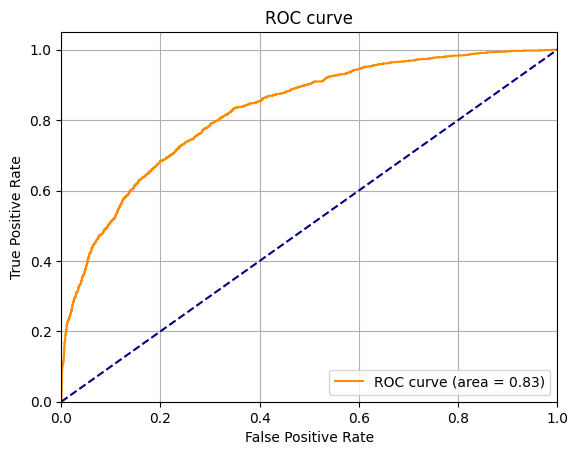

In [130]:
roc_auc_curve(y_train, lr.predict_proba(features_train)[:, 1])

Model: ROC AUC=0.729


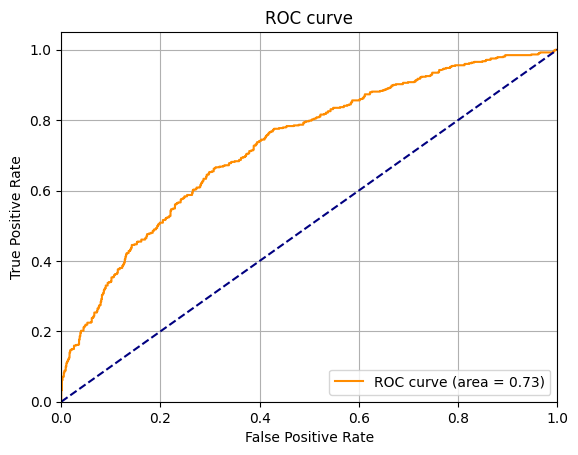

In [131]:
roc_auc_curve(y_test, lr.predict_proba(features_test)[:, 1])

In [36]:
svc = SVC(kernel='poly',
          degree=7,
          probability=True,
          random_state=RANDOM_STATE,
          class_weight='balanced').fit(features_train, y_train)

Model: ROC AUC=0.796


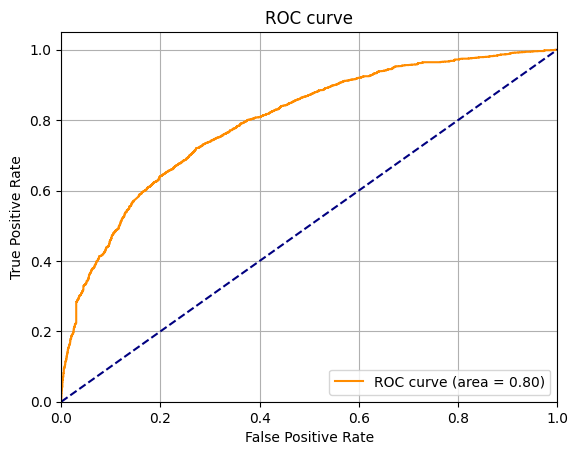

In [37]:
roc_auc_curve(y_train, svc.predict_proba(features_train)[:, 1])

Model: ROC AUC=0.722


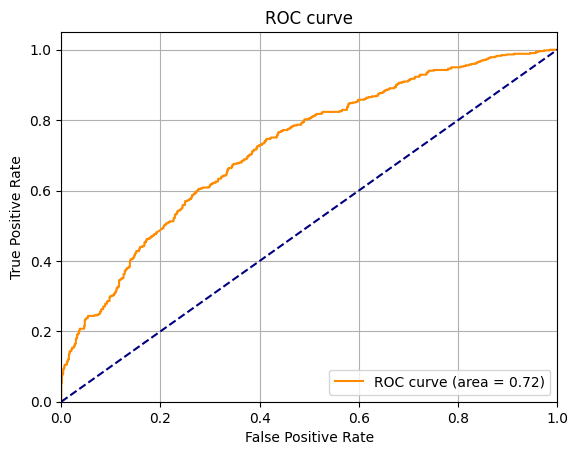

In [38]:
roc_auc_curve(y_test, svc.predict_proba(features_test)[:, 1])

In [51]:
knn = KNeighborsClassifier(n_neighbors=75).fit(features_train, y_train)

Model: ROC AUC=0.742


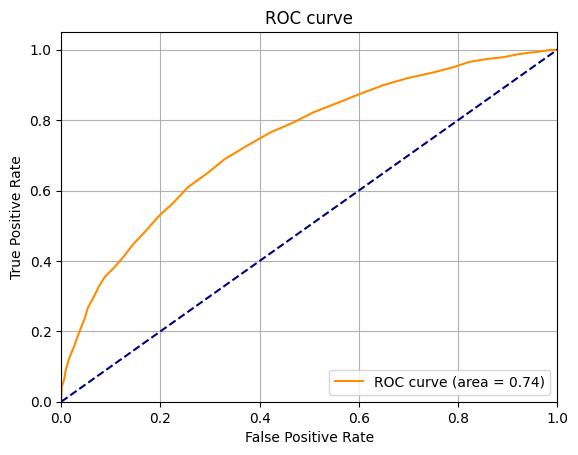

In [52]:
roc_auc_curve(y_train, knn.predict_proba(features_train)[:, 1])

Model: ROC AUC=0.706


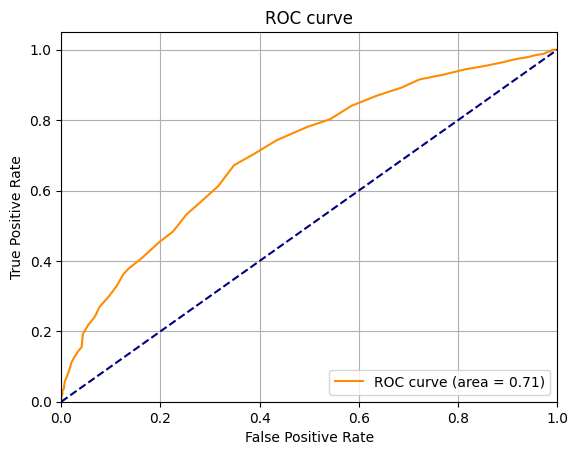

In [53]:
roc_auc_curve(y_test, knn.predict_proba(features_test)[:, 1])

In [67]:
rf = RandomForestClassifier(n_estimators=100,
                            class_weight='balanced',
                            random_state=RANDOM_STATE).fit(features_train, y_train)

Model: ROC AUC=1.000


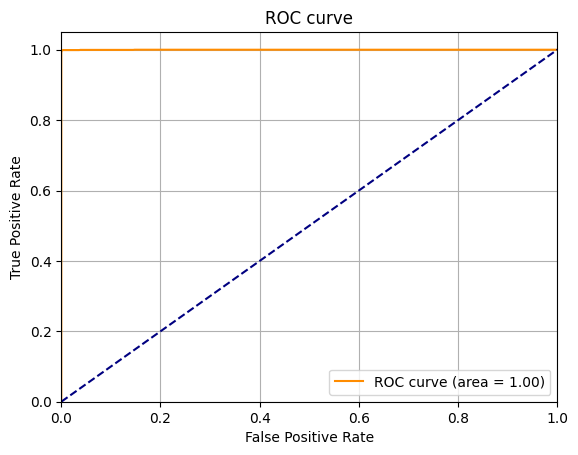

In [68]:
roc_auc_curve(y_train, rf.predict_proba(features_train)[:, 1])

Model: ROC AUC=0.706


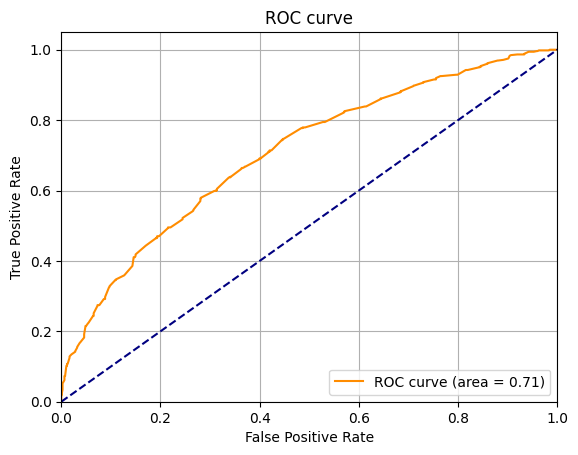

In [69]:
roc_auc_curve(y_test, rf.predict_proba(features_test)[:, 1])

In [79]:
%%time
brfc = BayesSearchCV(RandomForestClassifier(class_weight='balanced',
                                            random_state=RANDOM_STATE),
                     {'n_estimators': Integer(10, 250),
                      'max_depth': Integer(1, 10),
                      'min_samples_leaf': Integer(1, 100),
                      'max_features': Integer(1, 30)},
                     scoring='roc_auc',
                     cv=1,
                     verbose=2,
                     n_jobs=-1,
                     random_state=RANDOM_STATE).fit(features_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Python\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Python\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Python\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 40.3 s
Wall time: 9min 48s


In [113]:
#save_model(bscv_rf, 'models/bscv_rf.h5')
bscv_rf = load_model('models/bscv_rf.h5')

In [114]:
bscv_rf.best_params_

OrderedDict([('max_depth', 10),
             ('max_features', 11),
             ('min_samples_leaf', 1),
             ('n_estimators', 250)])

In [121]:
bscv_rf.best_score_

0.7289529434913607

In [122]:
bscv_rf.cv_results_['mean_test_score']

array([0.70372907, 0.71795261, 0.71216817, 0.71530251, 0.70788751,
       0.71405382, 0.71426409, 0.69381997, 0.71839349, 0.69931707,
       0.7234553 , 0.72877916, 0.72895294, 0.61680726, 0.7017161 ,
       0.71512157, 0.69835046, 0.68886452, 0.72420923, 0.72876224,
       0.72392938, 0.72846456, 0.70806075, 0.70557916, 0.72575351,
       0.68093911, 0.71249603, 0.67059566, 0.68358749, 0.72625641,
       0.7149503 , 0.72166226, 0.72641255, 0.72712096, 0.72564735,
       0.72877916, 0.72641255, 0.71198316, 0.72481691, 0.71493211,
       0.71621581, 0.6621988 , 0.72728689, 0.72877916, 0.6653685 ,
       0.68743505, 0.71082197, 0.72429695, 0.69350823, 0.70863875])

Model: ROC AUC=0.998


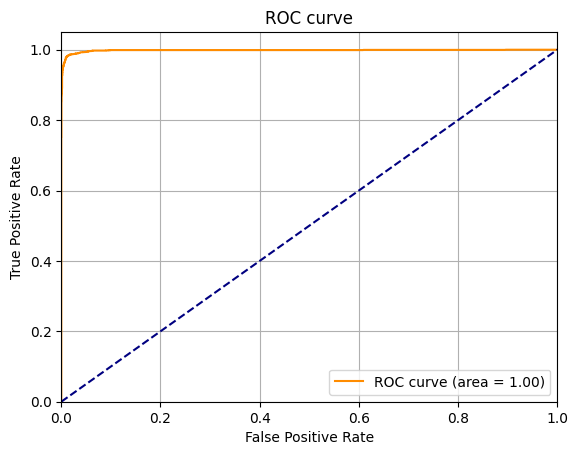

In [123]:
roc_auc_curve(y_train, bscv_rf.best_estimator_.predict_proba(features_train)[:, 1])

Model: ROC AUC=0.703


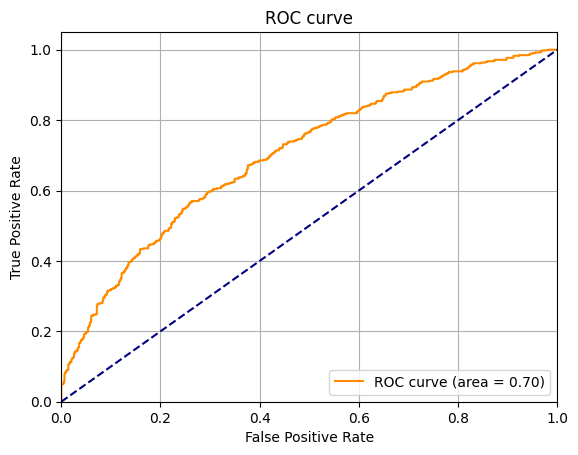

In [124]:
roc_auc_curve(y_test, bscv_rf.best_estimator_.predict_proba(features_test)[:, 1])